# Advanced Lane Line Finding Project
Finding lane lines is the first important thing to do when a self driving car drives on a road. With a camera on front of the car and a series of computer vision techniques, the lane line can be well detected and calculated for the self driving car system.

Following is the pipeline for the whole algorithm.
1. Camera calibration
2. Image undistort
3. Color space threshold and Gradient space threshold
4. Perspective transform
5. Laneline curve obtain using slidwindow with histogram
6. Radius of curvature calculate

for video

7. Laneline curve obtain using previous frame
8. Laneline curve smooth using previous frames


## 1 Camera calibration
Camera lens can cause the distortion of the light around the edges.These distortion will cause the shape and position change of the lines in the image. Self driving car is really important with precision. With camera calibration we can fix this.The calibration can be done with a known standart chessboard images and the distorted chessboard images taken with the camera. The calibration parameters can be calculated through the process.

In [1]:
# import needed package
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import glob
import pickle

### Finding ImgObjpoints
opencv have the chessboard coners find function that will helf obtain the image points from the images.

In [2]:
#prepare object points,like (0,0,0),(1,0,0),...,(9,6,0)
objp=np.zeros((9*6,3),np.float32)
objp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)

#Arrays to store object points and image points from all the images
objpoints=[]
imgpoints=[]

#Make a list of calibration images
images=glob.glob('camera_cal/calibration*.jpg')

for fname in images:
    img=mpimg.imread(fname)
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #find chessboardcorners
    ret,corners=cv2.findChessboardCorners(gray,(9,6),None)
    if ret==True:
        objpoints.append(objp)
        imgpoints.append(corners)

### Finding Calibratematrix and test
use the opencv calibration function to obtain the calibration matrix and save the calibration matrix.

True

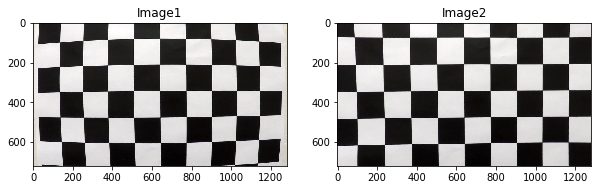

In [3]:

#find and save calibratematrix

#define the image size
img_size=(1280,720)
#calibrate the camera use objpoints ,imgpoints and image_size
ret,mtx,dist,rvecs,tvecs=cv2.calibrateCamera(objpoints,imgpoints,img_size,None,None)
#save the matrix
dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/dist_pickle.p", "wb" ) )

def undistort(image):
    #undistort the image
    dst=cv2.undistort(image,mtx,dist,None,mtx)
    return dst
    
#visualize the before and after
def show(image,dst):
    f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
    ax1.imshow(image,cmap='gray')
    ax1.set_title('Image1')
    ax2.imshow(dst,cmap='gray')
    ax2.set_title('Image2')

#test
image_test=mpimg.imread(images[0])
show(image_test,undistort(image_test))
cv2.imwrite('output_images/test.jpg',undistort(image_test))

## 2 Undistort the test images

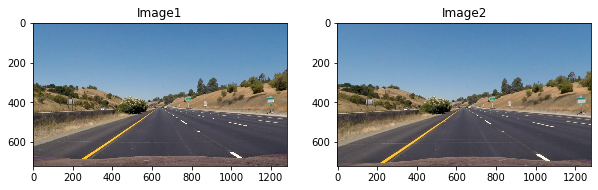

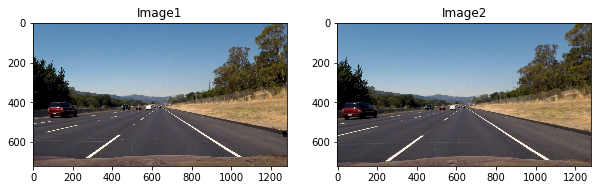

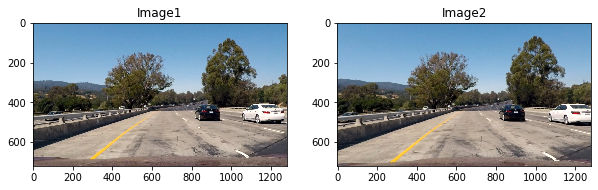

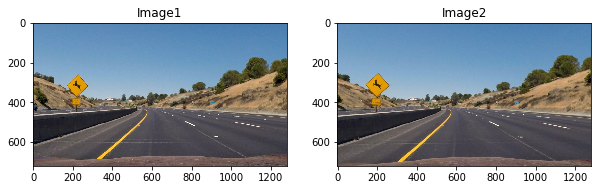

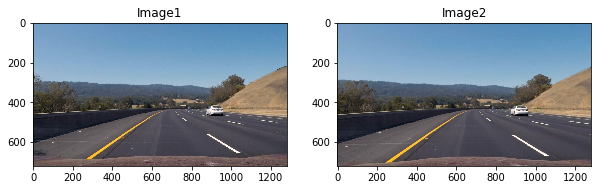

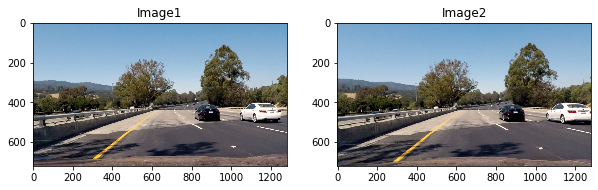

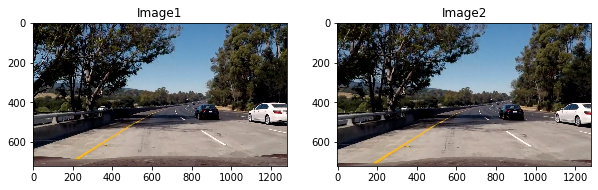

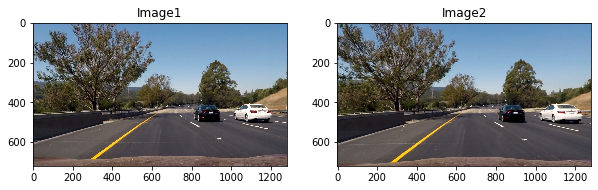

In [4]:
test_images=glob.glob('test_images/*.jpg')
for index,image in enumerate(test_images):
    img=mpimg.imread(image)
    undistort_image=undistort(img)
    show(img,undistort_image)
    undistort_image=cv2.cvtColor(undistort_image,cv2.COLOR_RGB2BGR)
    cv2.imwrite('test_images_undistort/test'+str(index+1)+'_undistort.jpg',undistort_image)

## 3 Thresholding
### Color threshold
The lane lines are special colors like yellow or white. This can be well detected in HSV/HLS colorspace. I choose the threshold from p1.

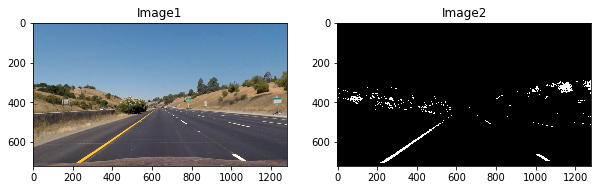

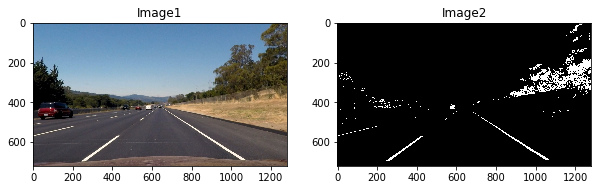

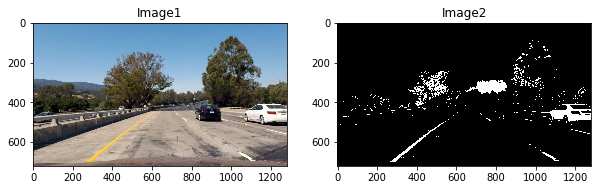

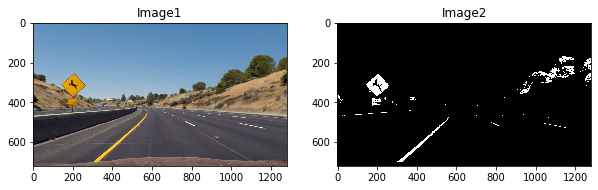

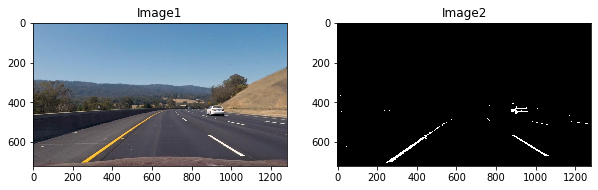

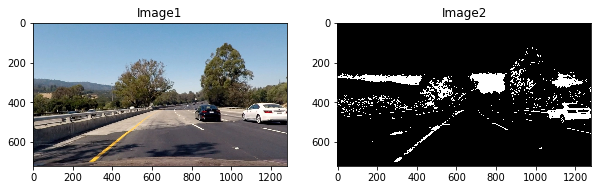

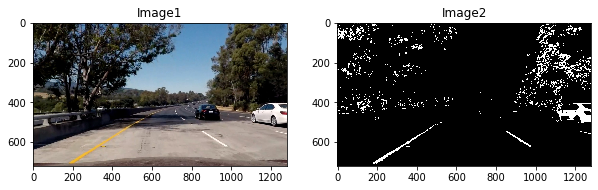

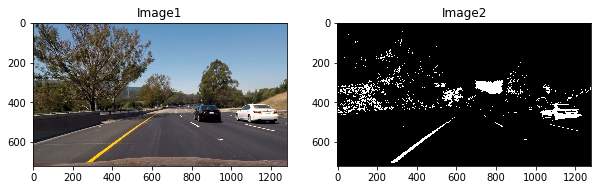

In [5]:
test_images_undistort=glob.glob('test_images_undistort/test*_undistort.jpg')
def hls_select(image,lower,upper):
    hls=cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    h=hls[:,:,0]
    l=hls[:,:,1]
    
    s=hls[:,:,2]
    binary_output=np.zeros_like(hls[:,:,0])
    binary_output[((h>=lower[0])&(h<=upper[0]))&((l>=lower[1])&(l<=upper[1]))&((s>=lower[2])&(s<=upper[2]))]=1
    return binary_output

lower_yellow=np.array([20,0,100])
upper_yellow=np.array([30,255,255])

lower_white=np.array([0, 200, 0])
upper_white=np.array([180, 255, 255])


for index,image in enumerate(test_images_undistort):
    image=mpimg.imread(image)
    hls_yellow=hls_select(image,lower_yellow,upper_yellow)
    hls_white=hls_select(image,lower_white,upper_white)
    output=np.zeros_like(hls_yellow)
    output[(hls_white==1)|(hls_yellow==1)]=1
    cv2.imwrite('test_images_colorthreshold/test'+str(index+1)+'_colorthreshold.jpg',output*255)
    show(image,output)
    


### Gradient Threshold
Gradient in x direction, y direction, magnitute of the gradient, direction of the gridient, these four method can be combined to get a better threshold of the lanlines.

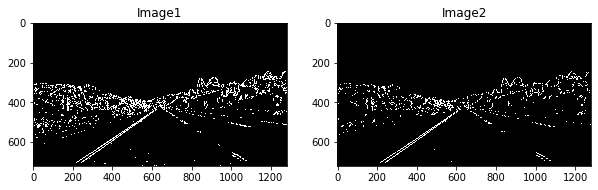

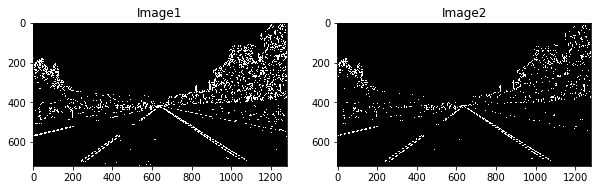

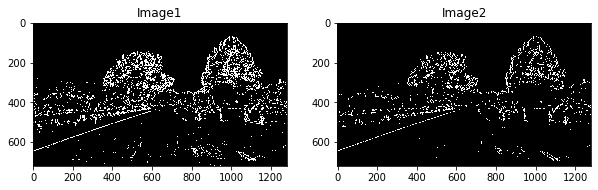

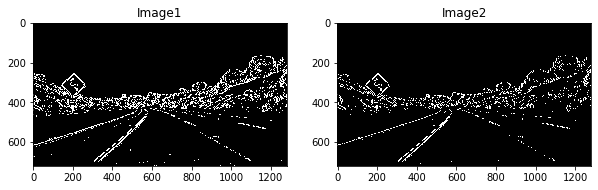

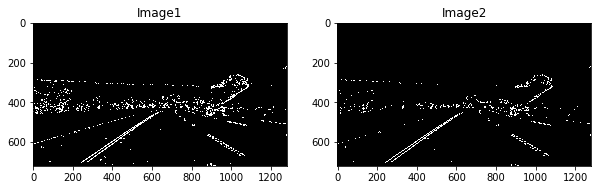

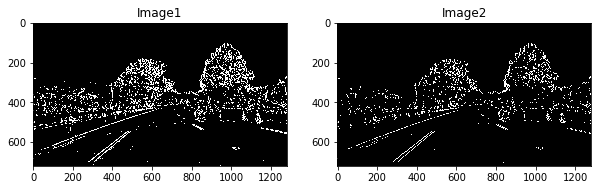

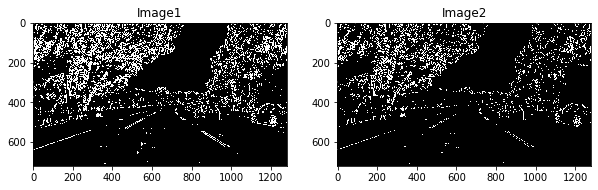

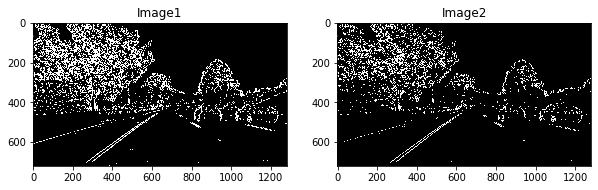

In [6]:
def abs_sobel_thresh(img, orient='x',ksize=3, thresh_min=0, thresh_max=255):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=ksize))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=ksize))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

for image in test_images_undistort:
    image=mpimg.imread(image)
#     iamge=cv2.GaussianBlur(image,(15,15),0)
    x_dir1=abs_sobel_thresh(image,'x',7,20,120)
    x_dir2=abs_sobel_thresh(image,'x',7,30,120) #choose this one, because it can resolve the noize in the third image
    show(x_dir1,x_dir2)
    

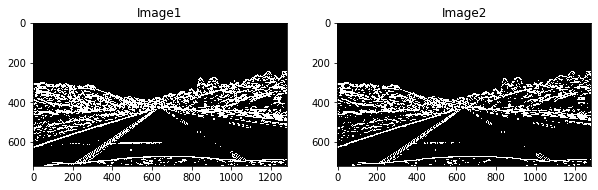

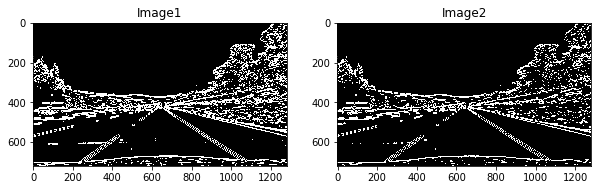

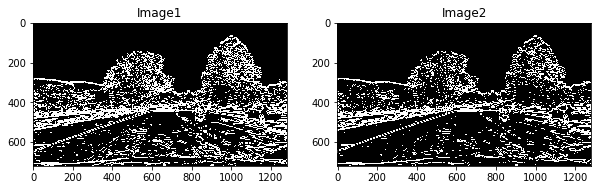

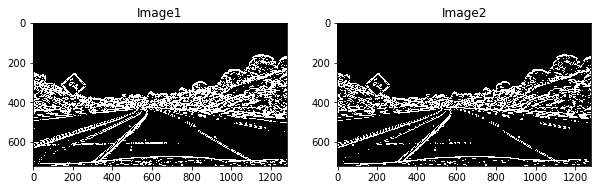

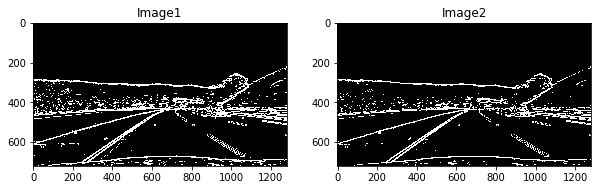

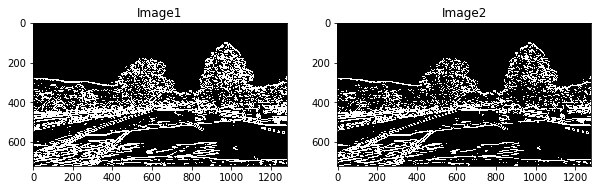

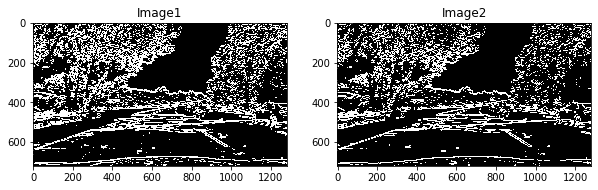

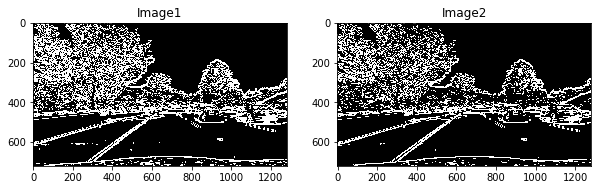

In [7]:
for image in test_images_undistort:
    image=mpimg.imread(image)
    iamge=cv2.GaussianBlur(image,(9,9),0)
    y_dir1=abs_sobel_thresh(image,'y',15,15,120)
    y_dir2=abs_sobel_thresh(image,'y',15,20,120) #choose this one for less noise
    show(y_dir1,y_dir2)

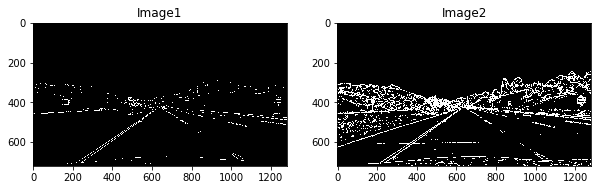

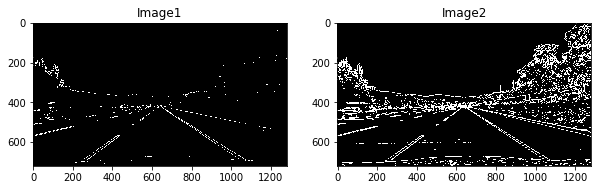

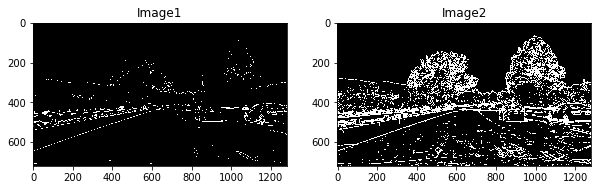

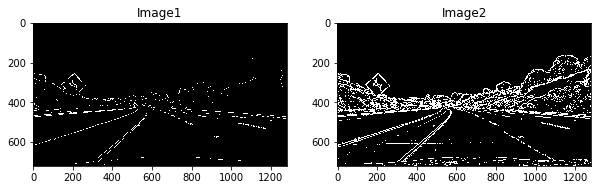

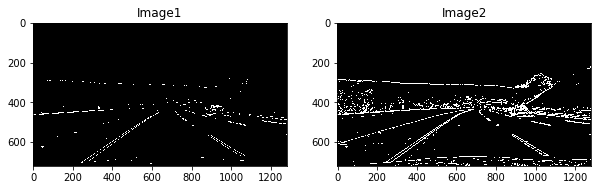

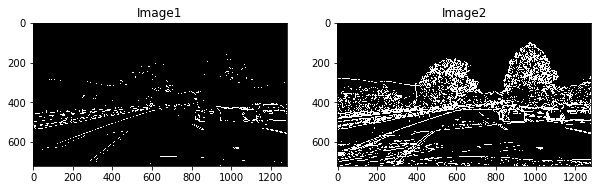

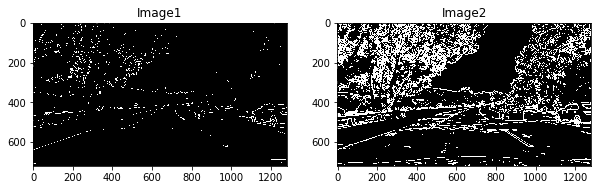

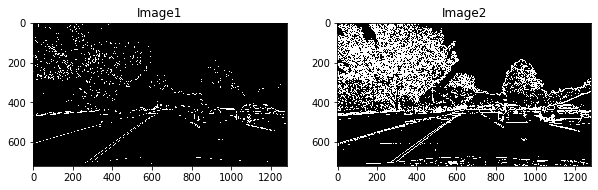

In [8]:
def mag_thresh(img, sobel_kernel=3, thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    gx=cv2.Sobel(gray,cv2.CV_64F,1,0)
    gy=cv2.Sobel(gray,cv2.CV_64F,0,1)
    # 3) Calculate the magnitude
    gm=(gx**2+gy**2)**0.5
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_gm=np.uint8(255*gm/np.max(gm))
    # 5) Create a binary mask where mag thresholds are met
    binary_output=np.zeros_like(scaled_gm)
    binary_output[(scaled_gm>=thresh_min)&(scaled_gm<=thresh_max)]=1
    # 6) Return this mask as your binary_output image
    return binary_output

for image in test_images_undistort:
    image=mpimg.imread(image)
    mag1=mag_thresh(image,15,70,200)
    mag2=mag_thresh(image,15,20,200)#choose this one for thicker line
    show(mag1,mag2)

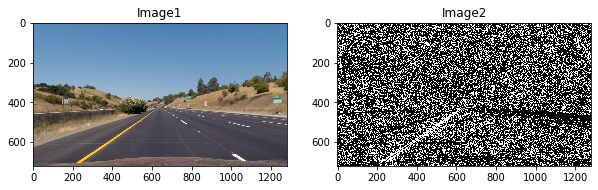

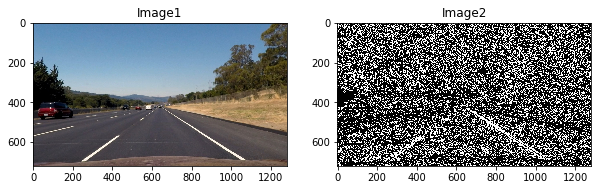

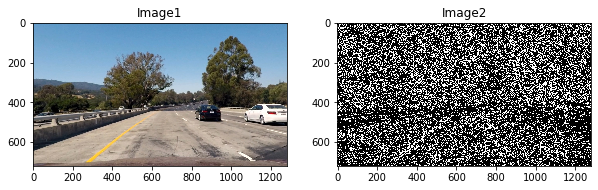

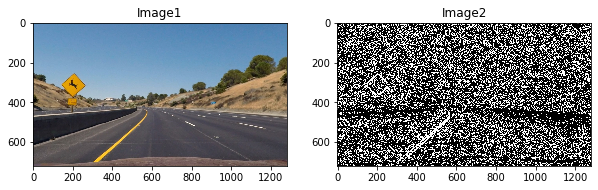

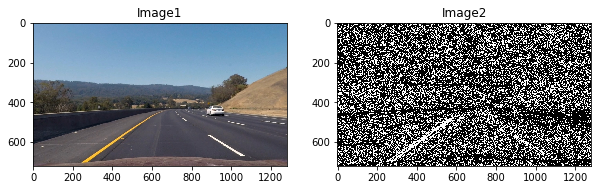

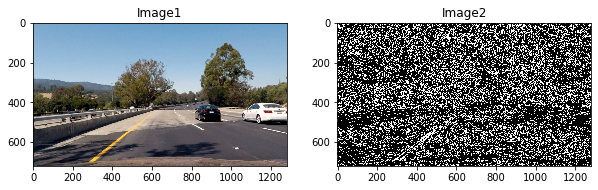

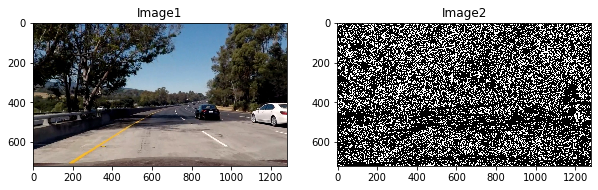

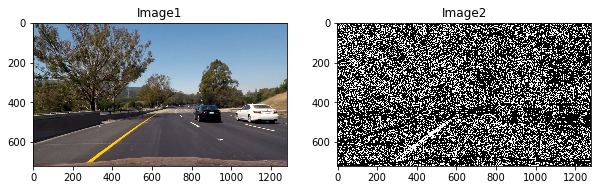

In [9]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
   # Apply the following steps to img
    # 1) Convert to grayscale
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    gx=np.abs(cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel))
    gy=np.abs(cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    dg=np.arctan2(gy,gx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output=np.zeros_like(dg)
    binary_output[(dg>=thresh[0])&(dg<=thresh[1])]=1
    # 6) Return this mask as your binary_output image
    return binary_output

for image in test_images_undistort:
    image=mpimg.imread(image)
    direction1=dir_threshold(image,5,(np.pi/6,np.pi*0.35))
#     direction2=dir_threshold(image,5,(np.pi/8,np.pi/4))
    show(image,direction1)
    
#from the filter result, the direction sobel filter will bring too much noise.

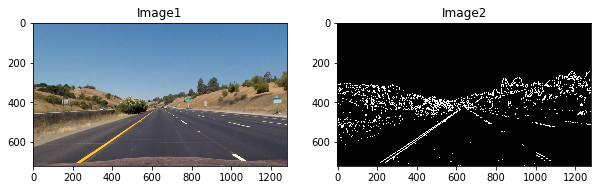

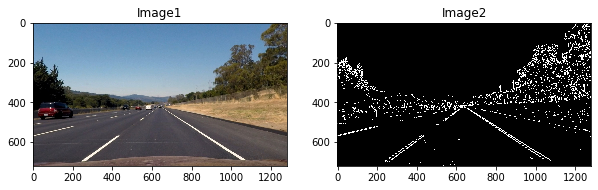

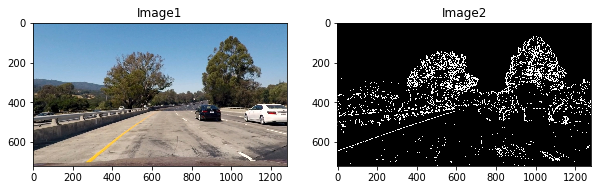

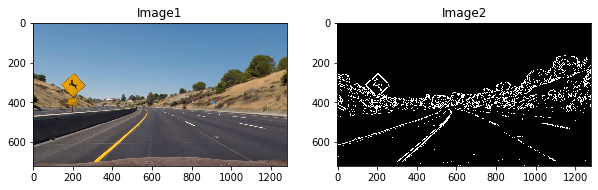

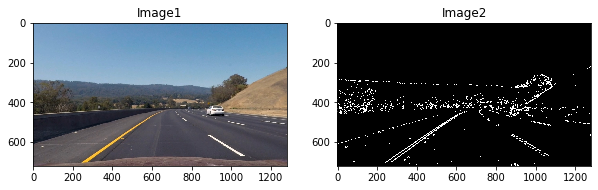

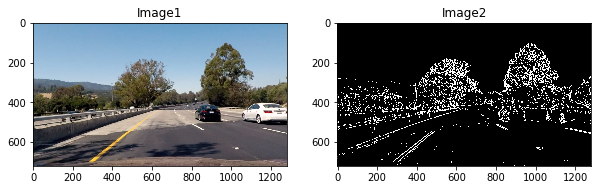

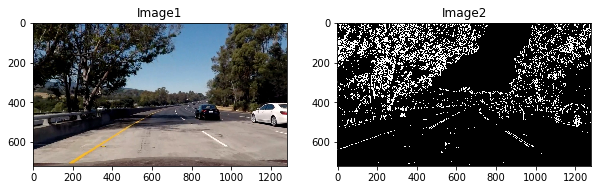

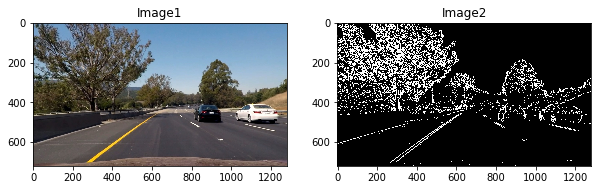

In [10]:
def combined_sobels(sx_binary, sy_binary, sxy_magnitude_binary,sxy_direction_binary):    
    combined = np.zeros_like(sx_binary)
    # Sobel X returned the best output so we keep all of its results. We perform a binary and on all the other sobels    
    combined[((sx_binary == 1) |((sy_binary==1)&(sxy_direction_binary==1)&(sxy_magnitude_binary==1)))] = 1
    return combined

for index,image in enumerate(test_images_undistort):
    image=mpimg.imread(image)
    sx_binary=abs_sobel_thresh(image,'x',5,20,120)
    sy_binary=abs_sobel_thresh(image,'y',15,20,120)
    sxy_magnitude_binary=mag_thresh(image,15,20,200)
    sxy_direction_binary=dir_threshold(image,5,(np.pi/6,np.pi*0.35))
    combine=combined_sobels(sx_binary, sy_binary, sxy_magnitude_binary,sxy_direction_binary)
    cv2.imwrite('test_images_sobelthreshold/test'+str(index+1)+'_sobelthreshold.jpg',combine*255)
    show(image,combine)


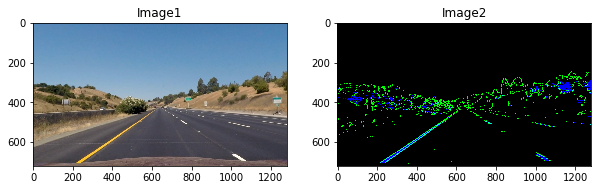

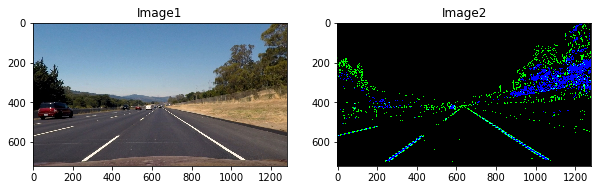

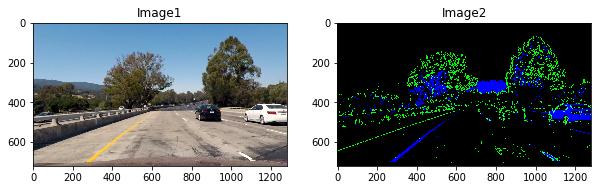

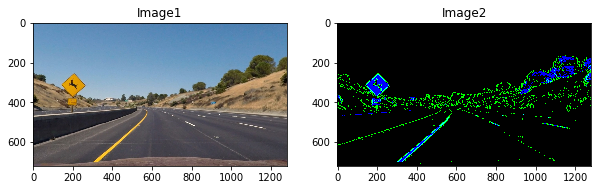

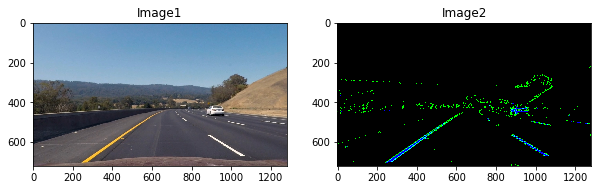

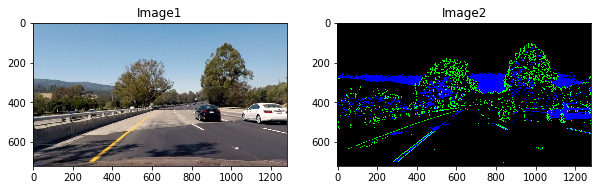

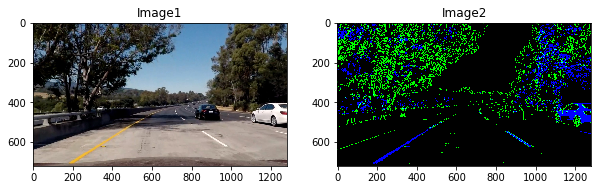

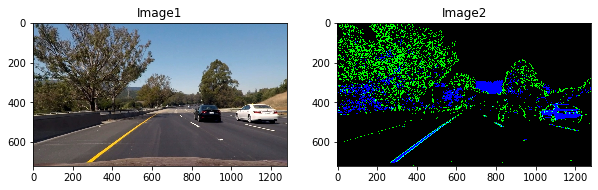

In [11]:
def combined_color_sobel(combine,color):
    color_binary = np.dstack(( np.zeros_like(combine),  combine,color)) *255
    return color_binary


for index,image in enumerate(test_images_undistort):
    image=mpimg.imread(image)
    sx_binary=abs_sobel_thresh(image,'x',7,30,120)
    sy_binary=abs_sobel_thresh(image,'y',15,20,120)
    sxy_magnitude_binary=mag_thresh(image,15,30,200)
    sxy_direction_binary=dir_threshold(image,5,(np.pi/6,np.pi*0.35))
    combine=combined_sobels(sx_binary, sy_binary, sxy_magnitude_binary,sxy_direction_binary)  
    
    lower_yellow=np.array([20,0,100])
    upper_yellow=np.array([30,255,255])
    lower_white=np.array([0, 200, 0])
    upper_white=np.array([180, 255, 255])
    hls_yellow=hls_select(image,lower_yellow,upper_yellow)
    hls_white=hls_select(image,lower_white,upper_white)
    color=np.zeros_like(hls_yellow)
    color[(hls_yellow==1)|(hls_white==1)]=1

    
    threshold_image=np.zeros_like(combine)
    threshold_image[(combine==1)|(color==1)]=1
    threshold_image=threshold_image*255
    threshold_image=cv2.cvtColor(threshold_image,cv2.COLOR_GRAY2BGR)
    cv2.imwrite('test_images_threshold/test'+str(index+1)+'_threshold.jpg',threshold_image)
    show(image,combined_color_sobel(combine,color))


## 4 Perspective transform
From different perspective, the shape, distance,curve can be different. In order to control the selfdriving car, the movement can be appromatily considered as on a plaform. To view from a bird's eye view is the best option.

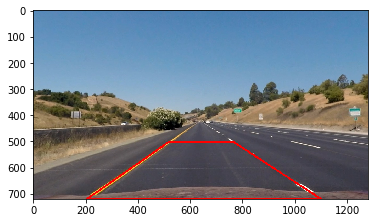

In [12]:
test1_image_undistort=mpimg.imread(test_images_undistort[0])
hight=test1_image_undistort.shape[0]
width=test1_image_undistort.shape[1]
bottom_left=[205,hight]
bottom_right=[1101,hight]
upper_left=[520,501]
upper_right=[764,501]
pts = np.array([bottom_left,upper_left,upper_right,bottom_right], np.int32)
cv2.polylines(test1_image_undistort,[pts],True,(255,0,0), 5)
plt.imshow(test1_image_undistort)

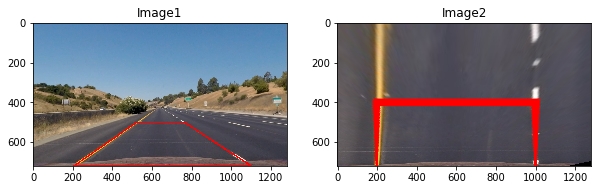

In [13]:
src= pts.astype(np.float32)
dst= np.array([[200, hight], [200,400], [1000, 400], [1000, hight]], np.float32)

M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)

#save the matrix
trans_matrix = {}
trans_matrix['M']= M
trans_matrix['M_inv'] = M_inv
pickle.dump( trans_matrix, open( "test_images_warped/trans_matrix.p", "wb" ) )

warped = cv2.warpPerspective(test1_image_undistort, M, img_size, flags=cv2.INTER_LINEAR)
show(test1_image_undistort,warped)

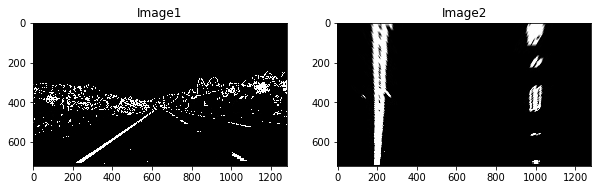

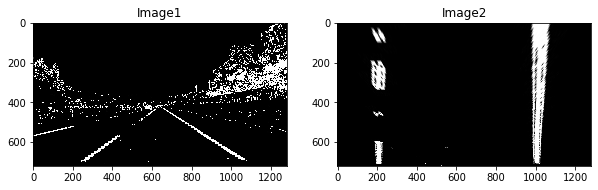

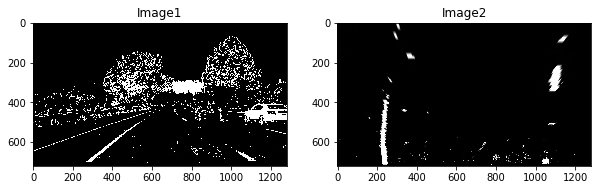

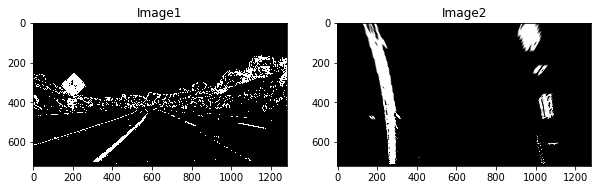

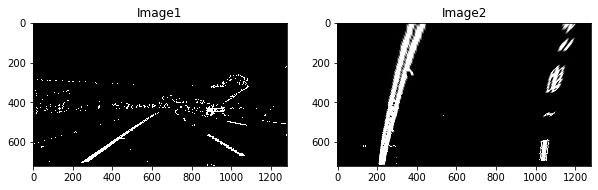

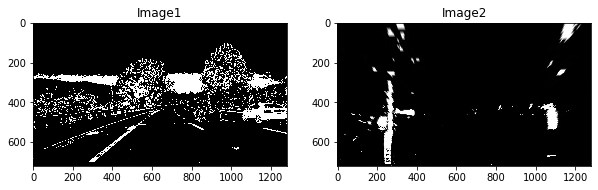

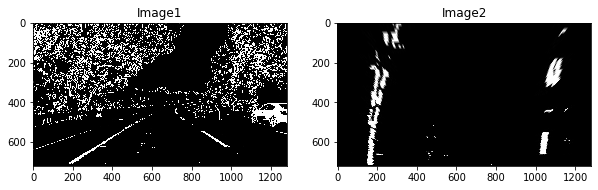

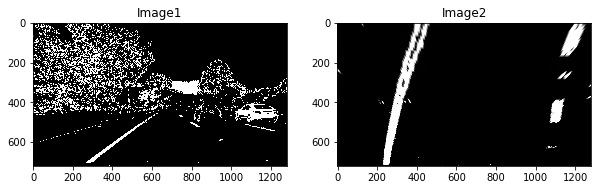

In [14]:
test_images_threshold=glob.glob('test_images_threshold/test*_threshold.jpg')
for index,image in enumerate(test_images_threshold):
    image=mpimg.imread(image)
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    warped_image=cv2.cvtColor(warped,cv2.COLOR_RGB2GRAY)
    cv2.imwrite('test_images_warped/test'+str(index+1)+'_warped.jpg',warped_image)
    show(image,warped)


### 5 Implement Sliding Windows and Fit a Polynomial

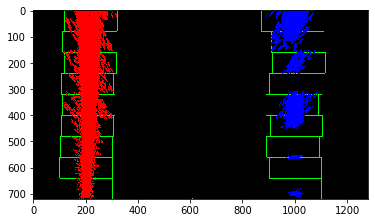

In [15]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the botom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin  # Update this
        win_xleft_high = leftx_current+margin  # Update this
        win_xright_low = rightx_current-margin  # Update this
        win_xright_high = rightx_current+margin # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy>=win_y_low)&(nonzeroy<win_y_high)&
        (nonzerox>=win_xright_low)&(nonzerox<win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds)>minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds)>minpix:
            rightx_current=np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')

    return ploty,left_fit,right_fit,out_img

test_images_warped=glob.glob('test_images_warped/test*_warped.jpg')

#test on an image
image=mpimg.imread(test_images_warped[0])
ploty,left_fit,right_fit,output=fit_polynomial(image)
cv2.imwrite('output_images/slidewindow.jpg',output)
plt.imshow(output)


### Calculate curvature

In [16]:
def measure_curvature_pixels(ploty,left_fit,right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

def measure_curvature_real(ploty,left_fit,right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

# Calculate the radius of curvature in pixels for both lane lines
left_curverad_pixels, right_curverad_pixels = measure_curvature_pixels(ploty,left_fit,right_fit)
left_curverad_real, right_curverad_real= measure_curvature_real(ploty,left_fit,right_fit)
print(left_curverad_pixels, right_curverad_pixels,left_curverad_real, right_curverad_real)

10765.330674974051 7035.816495123615 10713.93380928416 7067.438104155437


### Draw lines in image

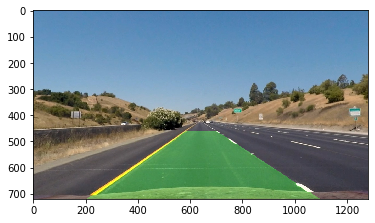

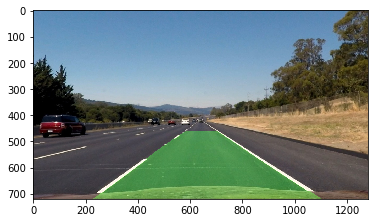

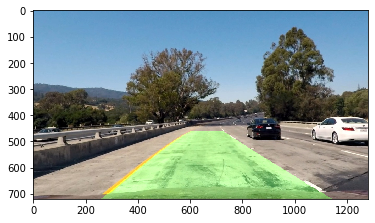

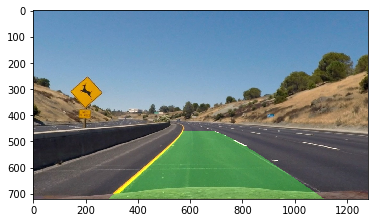

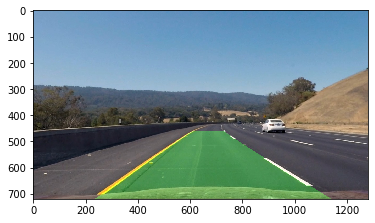

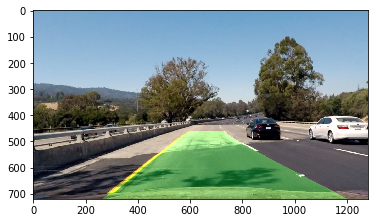

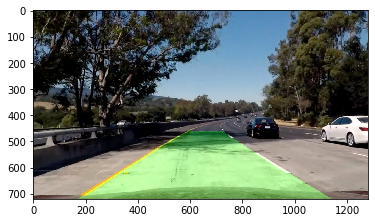

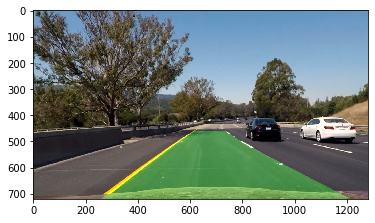

In [17]:
def drawLine(img, left_fit, right_fit):
    """
    Draw the lane lines on the image `img` using the poly `left_fit` and `right_fit`.
    """
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0])) 
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)


for i in range(len(test_images_undistort)):
    image1=mpimg.imread(test_images_undistort[i])
    image2=mpimg.imread(test_images_warped[i])
    ploty,left_fit,right_fit,output=fit_polynomial(image2)
    plt.figure()
    plt.imshow(drawLine(image1,left_fit,right_fit))
    cv2.imwrite('test_images_laneline/test'+str(i+1)+'_laneline.jpg',cv2.cvtColor(drawLine(image1,left_fit,right_fit),cv2.COLOR_RGB2BGR))
